In [368]:
# TGS Machine Learning Notebook
# Created by Brandon Clary
# 8/15/2016

import os
import sys
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [322]:
# set path relative to current directory
os.path.join(os.path.curdir, 'input/')
ABS_INPUT_PATH = os.path.join(os.path.curdir, 'input/') #/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/'
TEST_PATH = 'test/'
TRAIN_PATH = 'train/'
MASKS_PATH = 'masks/'
IMAGES_PATH = 'images/'
DEPTH_PATH = ABS_INPUT_PATH + TRAIN_PATH + 'depths.csv'
IMAGE_PROPERTIES = (128,128,1)

In [323]:
def getTrainImageNames():
    path_to_train =  ABS_INPUT_PATH + TRAIN_PATH + IMAGES_PATH
    return sorted(next(os.walk(path_to_train))[2])

In [324]:
def getTrainMaskNames():
    return sorted(next(os.walk(ABS_INPUT_PATH + TRAIN_PATH + MASKS_PATH))[2])

In [325]:
# depth is defined as "The value of the depth corresponds to the center of the image."
# The dictionary includes all images and all masks in the training set
def getImageDataDict():
    depth_of_images = {}
    with open(DEPTH_PATH, 'r') as f:
        x = f.read().splitlines()
        for line in x:
            image_name = line.split(',')[0]
            depth_to_center_of_image =  line.split(',')[1]
            depth_of_images[image_name] = depth_to_center_of_image
    return depth_of_images

In [326]:
def resizeImage(temp_image_array, new_dimensions):
    if( temp_image_array.shape == new_dimensions):
        return temp_image_array
    else:
        return resize(temp_image_array, new_dimensions, mode = 'constant', preserve_range=True)

In [327]:
def imageToArray(temp_image):
    return np.array(temp_image)[:,:,1]

In [328]:
def getImage(temp_path_to_image):
    return cv2.imread(temp_path_to_image)

In [329]:
#change 128x128 back to 101x101 later
sys.stdout.flush()

def getTrainingData(x_train_path, y_train_path, img_type = '.png', RESIZE = (128,128,1)):
    print 'Splitting training data into numpy array for images and masks'
    n_training_entries = len(getTrainImageNames())
    X_train = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], 1), dtype = np.uint8 )
    Y_train = np.zeros( (n_training_entries, RESIZE[0], RESIZE[1], 1), dtype = np.uint8 )
    for i, x in enumerate(getTrainImageNames()):
        X_train[i] = resizeImage(imageToArray(getImage(x_train_path+x)),RESIZE)
        Y_train[i] = resizeImage(imageToArray(getImage(y_train_path+x)),RESIZE)
    print '>> DONE '
    return X_train, Y_train

In [330]:
def randomizeTrainingData(x_training,y_training):
    if len(x_training) != len(y_training):
        raise Exception("Length do not match")
    indices = range(len(x_training))
    np.random.shuffle(indices)

    x_shuffled = [x_training[i] for i in indices]
    y_shuffled = [y_training[i] for i in indices]

    return x_shuffled, y_shuffled

In [361]:
x_train_path = ABS_INPUT_PATH + TRAIN_PATH + IMAGES_PATH
y_train_path = ABS_INPUT_PATH + TRAIN_PATH + MASKS_PATH
x_train_all, y_train_all = getTrainingData(x_train_path, y_train_path)
X_train, Y_train = randomizeTrainingData(x_train_all,y_train_all)
#print X_train[0]

Splitting training data into numpy array for images and masks
>> DONE 
[[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [116]
  [118]
  ...
  [113]
  [115]
  [  0]]

 [[  0]
  [109]
  [111]
  ...
  [114]
  [116]
  [  0]]

 ...

 [[  0]
  [ 85]
  [ 88]
  ...
  [124]
  [123]
  [  0]]

 [[  0]
  [ 78]
  [ 81]
  ...
  [118]
  [118]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]


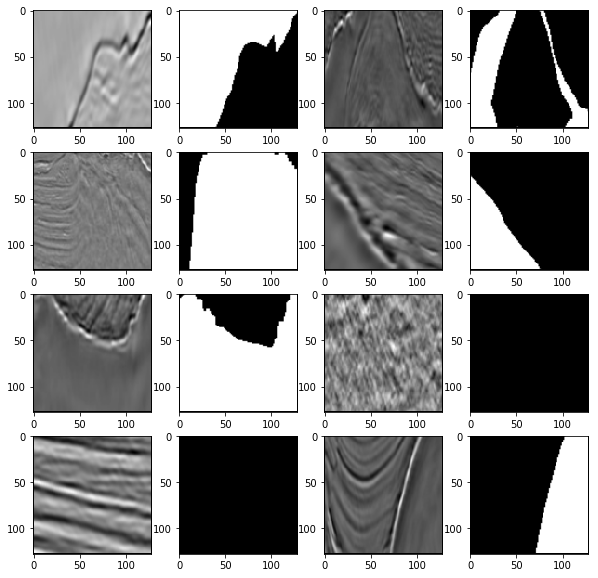

In [332]:
def checkTrainingData(x_data, y_data, n_rows = 4, n_col = 4):
    #write function to check the the formed training images and masks before sending to UNET
    f, axarr = plt.subplots(n_rows, n_col)
    f.set_size_inches((10,10))
    plot_factor = n_col/2
    x_shift = 2
    for i in range(n_rows):
        for j in range(plot_factor):
            get_random_img = np.random.randint(0,len(x_data))
            data = x_data[get_random_img]
            mask = y_data[get_random_img]
            #mask = np.squeeze(y_data[get_random_img]).astype(np.float32)
                        
            axarr[i,j*2].imshow(np.dstack((data,data,data)))
            axarr[i,2*j+1].imshow(np.dstack((mask,mask,mask)), cmap = 'gray')
            
checkTrainingData(X_train,Y_train)

In [363]:
def splitTraining(x_train, y_train, ratio_to_split):
    print 'Splitting Training set into a train and validation set'
    if ratio_to_split > 1.0 or ratio_to_split < 0.0:
        raise Exception("Specify split value between 0.0 and 1.0")
    
    train_lim = int(math.floor(ratio_to_split * len(x_train)))
    x_train_split = x_train[:train_lim]
    y_train_split = y_train[:train_lim]
    
    x_val_split = x_train[train_lim:]
    y_val_split = y_train[train_lim:]
    
    if ratio_to_split == 1.0:
        x_train_split = x_train
        y_train_split = y_train
        
    return x_train_split, y_train_split, x_val_split, y_val_split
    
x_train_split, y_train_split, x_val, y_val = splitTraining(X_train,Y_train,1.0)
print x_train_split[0]

Splitting Training set into a train and validation set
[[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [116]
  [118]
  ...
  [113]
  [115]
  [  0]]

 [[  0]
  [109]
  [111]
  ...
  [114]
  [116]
  [  0]]

 ...

 [[  0]
  [ 85]
  [ 88]
  ...
  [124]
  [123]
  [  0]]

 [[  0]
  [ 78]
  [ 81]
  ...
  [118]
  [118]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]


In [334]:
def augmentDataRotation(x_train, y_train, axis_to_rotate = 0):
    print 'Augmenting Data via Spatial Rotation'
    #x_test = np.flip(x_train, axis_to_rotate)
    x_aug = np.copy(x_train)
    y_aug = np.copy(y_train)
    for i in range(len(x_train)):
        x_aug[i] = np.flip(x_train[i],axis_to_rotate)
        y_aug[i] = np.flip(y_train[i],axis_to_rotate)        
    
    #f, axarr = plt.subplots(1,2)
    #axarr[0].imshow(np.dstack((x_test,x_test,x_test)))
    #axarr[1].imshow(np.dstack((x_og,x_og,x_og)))
    return x_aug, y_aug

Augment data to increase number of training instances
Augmenting Data via Spatial Rotation
[[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [115]
  [113]
  ...
  [118]
  [116]
  [  0]]

 [[  0]
  [116]
  [114]
  ...
  [111]
  [109]
  [  0]]

 ...

 [[  0]
  [123]
  [124]
  ...
  [ 88]
  [ 85]
  [  0]]

 [[  0]
  [118]
  [118]
  ...
  [ 81]
  [ 78]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]


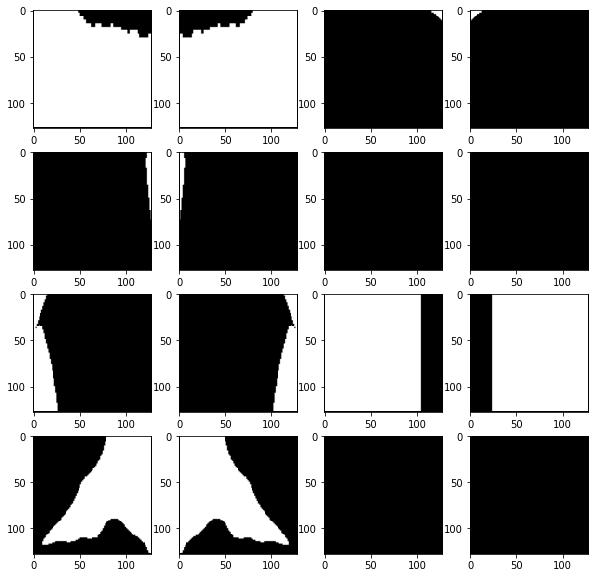

In [364]:
print 'Augment data to increase number of training instances'
X_aug_train, Y_aug_train = augmentDataRotation(x_train_split, y_train_split, 1)
checkTrainingData(Y_aug_train,Y_train)
print X_aug_train[0]

In [336]:
def addAugmentedData(x_train, x_aug_to_add, y_train, y_aug_to_add):
    x_new = np.concatenate((x_train,x_aug_to_add))
    y_new = np.concatenate((y_train,y_aug_to_add))
    return x_new, y_new

In [365]:
X_train_enhanced, Y_train_enhanced = addAugmentedData(x_train_split,X_aug_train,y_train_split,Y_aug_train)
print 'Concatenated the augmented data to the original data - total training size is now'
print len(X_train_enhanced)

print X_train_enhanced[0]

Concatenated the augmented data to the original data - total training size is now
8000
[[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [116]
  [118]
  ...
  [113]
  [115]
  [  0]]

 [[  0]
  [109]
  [111]
  ...
  [114]
  [116]
  [  0]]

 ...

 [[  0]
  [ 85]
  [ 88]
  ...
  [124]
  [123]
  [  0]]

 [[  0]
  [ 78]
  [ 81]
  ...
  [118]
  [118]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]


In [369]:
# Now it is time to build the CNN model.
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [370]:
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
#p1 = AveragePooling2D((2,2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 128, 128, 1)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 128, 128, 8)  80          lambda_10[0][0]                  
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 128, 128, 8)  584         conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [371]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 4000 arrays: [array([[[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [116],
        [118],
        ...,
        [113],
        [115],
      ...

In [ ]:
# BELOW IS A